# Topic Modeling #

This notebook shows how to prepare the data for topic modeling and how to analyze the data.

If you have already run the [hdp library](http://github.com/henridwyer/hdp) with your corpus, go directly to the section: [The Topics](#topics).

For context about the example data, see [data science jobs in new york](http://henri.io/posts/choosing-a-job-data-science-new-york.html).

## Parameters ##

In [36]:
# words that appear in fewer than MIN_DOC_FREQ documents will be ignored
MIN_DOC_FREQ = 20

# if there are less than MIN_WORDS in a document, it is dropped
MIN_WORDS = 10

In [2]:
from pymongo import MongoClient
import datetime
import reviews_data
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import re
import string
from gensim import corpora, models, similarities

In [3]:
# DB settings
client = MongoClient()
indeed_db = client.indeed
indeed_jobs = indeed_db.jobs
indeed_reviews = indeed_db.reviews
glassdoor_db = client.glassdoor
glassdoor_reviews = glassdoor_db.reviews

## Preparing the data ##

In [4]:
# this could also be the stemmed version - see db_access
all_reviews = reviews_data.get_combined_lower(indeed_reviews, glassdoor_reviews)
# all_reviews = reviews_data.get_stemmed_combined_reviews(indeed_reviews, glassdoor_reviews)
len(all_reviews)

196614

In [5]:
all_reviews[10090]

u'ok to work for, keep personal separate from business keep business separate from personal, low management, coworkers were ok to work with, hardest part of job was mainteance of paper work and most enjoyable was succeeding at goals and requirements. pros: great leaders cons: healthcare, understaffed'

### Stopwords ###

One problem of topic modeling has to do with common words that hold little meaning, e.g. 'the'. These words are very common, so the algorithm will focus on them. However, they bring little information about the topics.

The main way to deal with these so-called stopwords is to remove them during preprocessing. If you see such words in the topics at the end, you can come back to this step and add those words to the stop list.

In [6]:
# remove stop_words
stop = stopwords.words("english")
stop += ['.',',','(',')',"'",'"',':','','...','-','``',';',";'",'&']
stop += [str(i) for i in range(30)]
stop += ["'s", "n't", ]
stop += list(string.lowercase[:26])
stop += ['pro','con','pros','cons']
stop = set(stop) # sets are much faster to search

*Warning* : this step can be a bit slow.

In [7]:
# If you use stemmed words - you also need to stem the stopwords
# stemmer = PorterStemmer()
# stop = set([stemmer.stem(word) for word in stop])

preproc, doc_indexes = reviews_data.preprocess(all_reviews, stop, MIN_WORDS)

In [8]:
len(preproc)

183789

In [37]:
# assign id to words
dictionary = corpora.Dictionary(preproc)
# remove words that appear less than MIN_DOC_FREQ times
few_ids = [tokenid for tokenid, docfreq in dictionary.dfs.iteritems() if docfreq <= MIN_DOC_FREQ]
dictionary.filter_tokens(few_ids)
dictionary.compactify()

corpus = [dictionary.doc2bow(doc) for doc in preproc]
print dictionary

Dictionary(10673 unique tokens: [u'yellow', u'advices', u'hanging', u'cobit', u'localized']...)


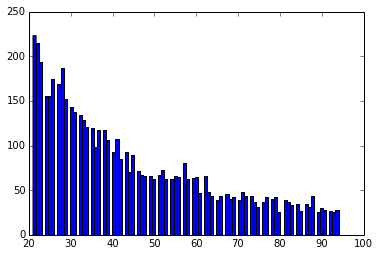

In [45]:
%matplotlib inline
# This can help choose MIN_DOC_FREQ
import matplotlib.pyplot as plt
plt.hist(sorted(dictionary.dfs.values())[:-5000], bins=100);

In [50]:
reviews_data.write_ldac("lda-c.txt", corpus)
dictionary.save_as_text("lda_dictionary.txt") #this will be used in the analysis
with open('doc_indexes.txt', 'w') as doc_indexes_file:
    for i in doc_indexes:
        doc_indexes_file.write("%s\n" % i)

## Run Topic Modeling Library ##

Now the data is ready to be used with hierarchical Dirichlet process, an extension of latent Dirichlet allocation. I used a library found on David M. Blei's page: http://www.cs.princeton.edu/~blei/topicmodeling.html, which I modified slightly so that it would work with large corpuses (over 32767 documents), and so that it saved the documents' topic's at the end. You can find the modified version on [github](http://github.com/henridwyer/hdp).

Follow the instructions and run:

```
./hdp --train_data lda-c.txt --directory output --verbose --sample_hyper --max_iter 1000 --max_time -1 --save_lag 100
```

Alternatively, you can use gensim or any other topic modeling library.

<a id='topics' />

# The Topics #

This next part assumes you used the hdp library described above, or at least that your outputs share the same format. It's written so you can start from here.

In [84]:
results_directory = "~/hdp/output/"
results_directory+= "final."
# how many topics to show
NB_OF_TOPICS = 10

# how many words per topic to show
NB_OF_WORDS = 20

In [85]:
import numpy as np
from gensim import corpora
dictionary = corpora.Dictionary.load_from_text("lda_dictionary.txt")
doc_indexes = []
with open('doc_indexes.txt') as doc_indexes_file:
    for line in doc_indexes_file:
        doc_indexes.append(int(line))

In [86]:
def sort_perm(vals, reverse=True):
    return sorted(range(len(vals)), key=vals.__getitem__, reverse=reverse)

def line_to_int(line):
    return [int(i) for i in line.split(' ')]

def topic_words(topic, n=10):
    return [dictionary[i] for i in sort_perm(line_to_int(topic))[:n]]

def read_f(name):
    with open(results_directory + name) as f:
        arr = []
        for l in f:
            try:
                arr.append(int(l.strip()))
            except ValueError:
                arr.append(float(l.strip()))
        return arr

In [87]:
counts = read_f("counts")

In [88]:
main_topicc_idx = sort_perm(counts)[:NB_OF_TOPICS]
main_topicc_idx

[0, 3, 5, 7, 4, 1, 8, 19, 21, 2]

In [89]:
hdp_out = open(results_directory + "topics")

i = 0
top_topics = [[0]]*NB_OF_TOPICS
all_topics = [[0]]*len(counts)
for line in hdp_out:
    all_topics[i] = line_to_int(line)
    if i in main_topicc_idx:
        top_topics[main_topicc_idx.index(i)] = line_to_int(line)
    i+=1
all_topics = np.array(all_topics)

## Most important topics and words ##

First let's look at the most common words in the most common topics.

In [90]:
all_topics.shape

(170, 10673)

In [91]:
for topic in top_topics:
    print [dictionary[i] for i in sort_perm(topic)[:NB_OF_WORDS]]

[u'work', u'good', u'great', u'life', u'balance', u'people', u'place', u'hours', u'pay', u'benefits', u'company', u'long', u'working', u'lot', u'career', u'opportunities', u'hard', u'nice', u'culture', u'compensation']
[u'one', u'work', u'would', u'job', u'time', u'even', u'make', u'years', u'manager', u'like', u'never', u'go', u'could', u'every', u'year', u'management', u'say', u'another', u'day', u'worked']
[u'people', u'get', u'like', u'company', u'really', u'know', u'want', u'much', u'employees', u'way', u'need', u'hard', u'think', u'also', u'many', u'best', u'well', u'working', u'things', u'give']
[u'opportunities', u'career', u'work', u'opportunity', u'training', u'many', u'development', u'within', u'growth', u'skills', u'different', u'management', u'employees', u'environment', u'experience', u'organization', u'team', u'large', u'professional', u'difficult']
[u'work', u'great', u'environment', u'place', u'working', u'team', u'fun', u'co', u'always', u'people', u'fast', u'producti

We want to see the most important words in each topics. That means both those that have the largest weight in a given topic, but also those that are unique to that topic. Words like 'get', 'work' or 'people' are very common and don't define a topic very well.

The parameters alpha and beta help control that trade off. Intuitively: larger beta -> filter out rare words in the corpus, larger alpha -> less common words in the topic. Alpha should be less than Beta.

Playing around with these parameters is important to get interesting results.

In [217]:
ALPHA = 0.0005
BETA = 0.0005

In [93]:
all_topics = np.array(all_topics)
topic_freqs = np.sum(all_topics, axis=1)
word_freq = np.sum(all_topics, axis=0)

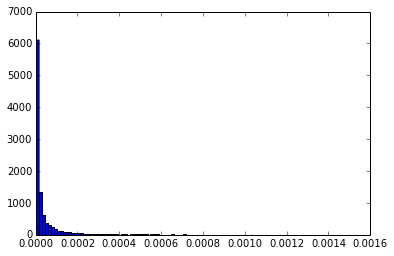

In [94]:
%matplotlib inline 
# this helps choose beta - not too far from where the main frequencies are.
import matplotlib.pyplot as plt
plt.hist(sorted(word_freq.astype(float)/np.sum(word_freq))[:-100], bins=100);

In [95]:
import csv
import os.path

def export_wordcloud(topic, ratio,k, fname):
    fname = fname +'.tsv'
    exists = os.path.isfile(fname)
    with open(fname, 'a') as csvfile:
        topic_writer = csv.writer(csvfile, delimiter='\t')
        if not exists: #write headers
            topic_writer.writerow(['topic','text','size','ratio'])
        most_important_words = sort_perm(topic)[:NB_OF_WORDS]
        for i in most_important_words:
            topic_writer.writerow([k,dictionary[i], topic[i], ratio[i]])

def write_topics(topics_indexes, export = False, name = ""):
    topics_list = []
    
    topic_freqs_normalized = topic_freqs.copy()/float(sum(topic_freqs))
    for k,idx in enumerate(topics_indexes):
        topic = (all_topics[idx].astype(float)/sum(all_topics[idx]) + ALPHA) / (word_freq.astype(float)/np.sum(word_freq) + BETA)
        topic /=max(topic)
        topic*= 1000
        ratio = np.array(all_topics[idx]) / np.array(word_freq).astype(float)
        ratio /= max(ratio)
        ratio += np.array(0.2)
        ratio /= max(ratio)
        if export:
            if not name:
                name = 'topic_'+ str(k)
            export_wordcloud(topic, ratio,k, name)
        else:
            most_important_words = sort_perm(topic)[:NB_OF_WORDS]
            topics_list.append([dictionary[i] for i in most_important_words])
    
    if not export:
        return topics_list

To tweak alpha and beta, here you can see how common the words selected are in the largest topics. A 2-5 ratio seems to give good results.

In [221]:
def sum_rank(arr, ref):
    return sum([ref.index(a) for a in arr])
init = 0
changed = 0
n = 20
for i in range(10):
    topic = (all_topics[i].astype(float)/sum(all_topics[i]) + ALPHA) / (word_freq.astype(float)/np.sum(word_freq) + BETA)
    init += sum_rank(sort_perm(top_topics[i])[:n], sort_perm(word_freq))
    changed += sum_rank(sort_perm(topic)[:n], sort_perm(word_freq))
print init
print changed

13829
62226


In [218]:
write_topics(main_topicc_idx)

[[u'balance',
  u'life',
  u'good',
  u'work',
  u'hours',
  u'place',
  u'flexible',
  u'long',
  u'nice',
  u'lots',
  u'compensation',
  u'pay',
  u'flexibility',
  u'hard',
  u'career',
  u'great',
  u'ok',
  u'lot',
  u'home',
  u'opportunities'],
 [u'never',
  u'even',
  u'told',
  u'one',
  u'another',
  u'would',
  u'left',
  u'got',
  u'say',
  u'reason',
  u'manager',
  u'months',
  u'two',
  u'tell',
  u'go',
  u'someone',
  u'last',
  u'could',
  u'person',
  u'ever'],
 [u'get',
  u'want',
  u'think',
  u'know',
  u'try',
  u'give',
  u'like',
  u'way',
  u'anyone',
  u'stop',
  u'else',
  u'anything',
  u'right',
  u'ca',
  u'people',
  u'really',
  u'done',
  u'trying',
  u'everyone',
  u'actually'],
 [u'opportunities',
  u'career',
  u'development',
  u'skills',
  u'opportunity',
  u'within',
  u'develop',
  u'knowledge',
  u'roles',
  u'organization',
  u'across',
  u'grow',
  u'skill',
  u'areas',
  u'teams',
  u'growth',
  u'role',
  u'limited',
  u'ability',
  u'reso

<a id="filtering" />

## Filtering Topics ##

Now that we've seen the most common topics, we can get to the main part: filtering topics based the company (or other criteria).

The parameters alpha and beta here serve the same purpose as above, but for identifying most important topics (and not words). Since there are far fewer topics, these should be much larger.

In [223]:
ALPHA_T = 0.01
BETA_T = 0.01

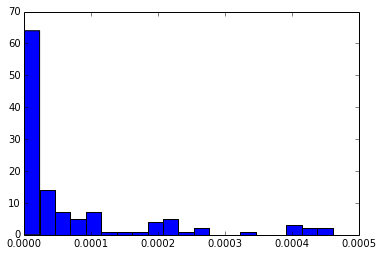

In [111]:
%matplotlib inline 
# this helps choose beta - not too far from where the main frequencies are.
import matplotlib.pyplot as plt
plt.hist(sorted(np.array(counts)/float(sum(counts)))[:-50], bins=20);

In [108]:
from pymongo import MongoClient
import reviews_data
import utils
# DB settings
client = MongoClient()
indeed_db = client.indeed
indeed_jobs = indeed_db.jobs
indeed_reviews = indeed_db.reviews
glassdoor_db = client.glassdoor
glassdoor_reviews = glassdoor_db.reviews

In [109]:
ratings = reviews_data.all_ratings(indeed_reviews, glassdoor_reviews)

# Drop ratings from reviews that were dropped
kept_ratings_temp = []
for i in doc_indexes:
    kept_ratings_temp.append(ratings[i])
ratings = kept_ratings_temp

In [110]:
# Read doc states
with open(results_directory + "doc.states") as f:
    doc_states = []
    for l in f:
        doc_states.append([int(i) for i in l.strip().split(' ')])

In [53]:
len(ratings)

183789

In [54]:
len(doc_states) # the number of ratings and documents should be the same

183789

<a id="company" />

## Topics By Company ##

In [55]:
companies = list(set(utils.get_company_names(indeed_reviews)))

In [56]:
def company_topics(company, output = False):
    top_sum = np.array([0]*len(all_topics))
    count = 0
    for i in range(len(ratings)):
        if ratings[i]['company'] == company:
            count += 1
            top_sum += np.array(doc_states[i])
    if output:      
        print("Number of reviews for " + company + ": " + str(count))
    return top_sum

# most disproportionately common topics
def largest_topics(topic, topic_freqs, alpha, beta):
    topic = np.array(topic.copy()).astype(float)
    topic /= sum(topic)
    return (topic + alpha)/(topic_freqs/float(sum(topic_freqs)) + beta)

To tweak alpha and beta, here you can see how common the topics selected are. A 2-5 ratio seems to give good results.

In [224]:
n = 10
init, changed = 0,0
for i in range(10):
    company_tops = largest_topics(company_topics(company, False), topic_freqs, ALPHA_T, BETA_T)
    init += sum_rank(sort_perm(company_topics(company, False))[:n], sort_perm(topic_freqs))
    changed += sum_rank(sort_perm(company_tops)[:n], sort_perm(topic_freqs))
print init
print changed

660
1350


In [225]:
company = companies[15]
print(company)

company_tops = largest_topics(company_topics(company, True), topic_freqs, ALPHA_T, BETA_T)
write_topics(sort_perm(company_tops)[:NB_OF_TOPICS])

Verizon
Number of reviews for Verizon: 8913


[[u'cable',
  u'customer',
  u'call',
  u'comcast',
  u'phone',
  u'service',
  u'customers',
  u'center',
  u'internet',
  u'verizon',
  u'calls',
  u'wireless',
  u'union',
  u'services',
  u'installation',
  u'satisfied',
  u'equipment',
  u'billing',
  u'issues',
  u'phones'],
 [u'sales',
  u'reps',
  u'store',
  u'retail',
  u'quota',
  u'commission',
  u'pressure',
  u'goals',
  u'rep',
  u'sell',
  u'quotas',
  u'face',
  u'territory',
  u'goal',
  u'numbers',
  u'sale',
  u'selling',
  u'meet',
  u'customer',
  u'unrealistic'],
 [u'excellent',
  u'great',
  u'room',
  u'advancement',
  u'security',
  u'benefits',
  u'company',
  u'wonderful',
  u'none',
  u'awesome',
  u'verizon',
  u'overall',
  u'training',
  u'recommend',
  u'advance',
  u'amazing',
  u'love',
  u'job',
  u'best',
  u'professional'],
 [u'fun',
  u'fast',
  u'productive',
  u'paced',
  u'enjoyed',
  u'workplace',
  u'environment',
  u'team',
  u'co',
  u'friendly',
  u'always',
  u'place',
  u'pace',
  u'ever

<a id="rating" />

## Topics by Rating ##

In [256]:
# Reminder about ratings
print ratings[0]

{'rating': u'5.0', 'Management': 5, 'company': u'American Express', 'Work and Life Balance': 5, 'Compensation and Benefits': 5, 'Culture and Values': 5, 'Career Opportunities': 5}


In [226]:
top_sum = np.array([0]*len(all_topics))
count = 0
for i in range(len(ratings)):
    if 'Career Opportunities' in ratings[i] and ratings[i]['Career Opportunities'] == 1:
        count += 1
        top_sum += np.array(doc_states[i])

print("Number of reviews: " + str(count))
        
rating_tops = largest_topics(top_sum, topic_freqs, ALPHA_T, BETA_T)
write_topics(sort_perm(rating_tops)[:NB_OF_TOPICS])

Number of reviews: 18249


[[u'horrible',
  u'treat',
  u'women',
  u'favoritism',
  u'respect',
  u'hr',
  u'unprofessional',
  u'terrible',
  u'treated',
  u'worst',
  u'treatment',
  u'human',
  u'poor',
  u'upper',
  u'favorites',
  u'boys',
  u'unethical',
  u'management',
  u'behavior',
  u'club'],
 [u'never',
  u'even',
  u'told',
  u'one',
  u'another',
  u'would',
  u'left',
  u'got',
  u'say',
  u'reason',
  u'manager',
  u'months',
  u'two',
  u'tell',
  u'go',
  u'someone',
  u'last',
  u'could',
  u'person',
  u'ever'],
 [u'ibm',
  u'cost',
  u'outsourcing',
  u'layoffs',
  u'cutting',
  u'cut',
  u'costs',
  u'jobs',
  u'india',
  u'term',
  u'outsourced',
  u'stock',
  u'bottom',
  u'morale',
  u'price',
  u'stop',
  u'years',
  u'profit',
  u'overseas',
  u'cuts'],
 [u'get',
  u'want',
  u'think',
  u'know',
  u'try',
  u'give',
  u'like',
  u'way',
  u'anyone',
  u'stop',
  u'else',
  u'anything',
  u'right',
  u'ca',
  u'people',
  u'really',
  u'done',
  u'trying',
  u'everyone',
  u'actually'

## Word Cloud ##

To visualize the topics using d3 in a word cloud, you can use the write_topics function. To see the html and javascript to visualize them, check out the example: [topics wordcloud](http://henri.io/posts/choosing-a-job#topics.html).

In [230]:
topics_file_name = "all_topics"
write_topics(range(len(all_topics)), True, topics_file_name)

In [228]:
# make a dictionary of various topics distributions:
topic_distributions = {}
topic_distributions['Main Topics'] = main_topicc_idx
for company in companies:
    topic_distributions[company] = sort_perm(largest_topics(company_topics(company), topic_freqs, ALPHA_T, BETA_T))[:NB_OF_TOPICS];

# you can add other choices here for instance based on ratings' criteria

#topic_distributions

In [229]:
import json
with open("topic_distributions.json" ,'w') as f:
    json.dump(topic_distributions, f)